## <font color = 'darkgreen'> **Packages** </font>

In [ ]:
from MCEq.core import config, MCEqRun
import crflux.models as crf
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

## <font color = 'darkblue'> **Functions** </font>

In [ ]:
## Function for the average amount of muons from ALL sources
def mean_muons(energy:int, particle: str, month: str, interaction = 'SIBYLL23C'):
    mceq = MCEqRun(
    interaction_model = interaction, # High-energy hadronic interaction model
    primary_model = (crf.HillasGaisser2012, 'H3a'),   # cosmic ray flux at the top of the atmosphere
    theta_deg = 0.  # zenith angle - 0 indicates vertical airshower
    )

    if particle == 'p':
        mceq.set_single_primary_particle(energy, pdg_id=2212) # energies are in units of GeV

    elif particle == 'fe':
        mceq.set_single_primary_particle(energy, corsika_id = 5626) # energies are in units of GeV
    
    h_grid = np.linspace(50 * 1e3 * 1e2, 283500) # altitudes up until observation level of IceCube (in cm)
    X_grid = mceq.density_model.h2X(h_grid)
    mceq.set_density_model(('MSIS00_IC', ('SouthPole', month)))
    
    mceq.solve(int_grid = X_grid)

    dN = mceq.get_solution('mu+', integrate = True) + mceq.get_solution('mu-', integrate = True)
    dE = mceq.e_widths   # bin width of energies
    dNdE = dN / dE   # energy spectrum of muons 
    E = mceq.e_grid

    return E, dNdE

## Function for the number of muons
def num_muons(energy:int, particle: str, month: str, interaction = 'SIBYLL23C'):
    mceq = MCEqRun(
    interaction_model = interaction, # High-energy hadronic interaction model
    primary_model = (crf.HillasGaisser2012, 'H3a'),   # cosmic ray flux at the top of the atmosphere
    theta_deg = 0.  # zenith angle - 0 indicates vertical airshower
    )

    if particle == 'p':
        mceq.set_single_primary_particle(energy, pdg_id=2212) # energies are in units of GeV

    elif particle == 'fe':
        mceq.set_single_primary_particle(energy, corsika_id = 5626) # energies are in units of GeV
    
    h_grid = np.linspace(50 * 1e3 * 1e2, 283500) # altitudes up until observation level of IceCube (in cm)
    X_grid = mceq.density_model.h2X(h_grid)
    mceq.set_density_model(('MSIS00_IC', ('SouthPole', month)))
    
    mceq.solve(int_grid = X_grid)
    num = mceq.n_mu(grid_idx=None, min_energy_cutoff = 500) # we want to know the number of muons ABOVE 500 GeV since that is what IceCube can detect

    return num

## <font color = 'darkred'> **Plot the Muon Spectrum** </font>

> **Goal: Create an airshower for different atmospheres**
> 
> 1. Create a function that inputs the energy, month, particle (proton or iron), and interactions (start with 2.3c)
> * Use *set_density*, Model *ms100_IC*
> * Create ratio of $\frac{\text{Month}}{\text{Yearly Average}}$, (Yearly Avg = (Sum all months /12)) 
> * Use range 1 - 1000 PeV for the primary energies 
> * Set observation level to 2835 m - might be in cms in mceq so convert if necessary
> * grid - maxmimum value at observation level convert to 
> 2. Save data to text files
> * This is to save time when creating plots as the data will already be stored in one particular location
> 3. Plot 
> * Range the energy spectrum (*E_grid*) from 100 GeV to 100 TeV 
> * grid - maxmimum value at observation level convert to 
> * Use red to denote proton primary and use blue to denote iron primary
> * Make seperate plots for proton and iron
> * Top plot will be to plot the yearly average
> * Bottom plot will be the ratio of the months to the yearly average
> * **Note that the vertical axis is the number of muons per an energy segment and the horiztonal axis is the energy spectrum**

### <font color = 'darkblue'> **Creating Text Files** </font>

In [ ]:
energies = [1, 10, 100, 1000] # 4 values of energies for the primary energies (10 - 100 PeV) (10e6  - 100e6 GeV)
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Average']

In [ ]:
for particle in ['p', 'fe']:
    for energy in energies:
        p_sum = np.zeros(121)
        fe_sum = np.zeros(121)
        for m in month:
            if (m != 'Average'):  # in other words, if it is a month
                E, dNdE = mean_muons(energy*(1e6), particle, m)
            
                if particle == 'p':
                    for k in range(121):
                            p_sum[k] = p_sum[k] + dNdE[k]
                    np.savetxt('Proton/'+ str(energy) + 'PeV/' + m +'_'+ str(energy)+ 'PeV.txt', np.column_stack([E, dNdE]), header="Emu(GeV)\tdNdE(1/GeV)")
                if particle == 'fe':
                    for k in range(121):
                        fe_sum[k] = fe_sum[k] + dNdE[k]
                    np.savetxt('Fe/' + str(energy) +'PeV/' + m +'_' +str(energy) + 'PeV.txt', np.column_stack([E, dNdE]), header="Emu(GeV)\tdNdE(1/GeV)")

            if (m == 'Average'):
                if particle == 'p':
                    p_avg = p_sum / 12
                    np.savetxt('Proton/' + str(energy) +'PeV/' + m +'_'+ str(energy)+ 'PeV.txt', np.column_stack([E, p_avg]), header="Emu(GeV)\tdNdE(1/GeV)")
                if particle == 'fe':
                    fe_avg = fe_sum / 12
                    np.savetxt('Fe/'+ str(energy)+ 'PeV/' + m +'_' +str(energy) + 'PeV.txt', np.column_stack([E, fe_avg]), header="Emu(GeV)\tdNdE(1/GeV)")

### <font color = 'purple'> **Plots** </font>

In [12]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Average']
colors = ['saddlebrown','firebrick', 'orangered', 'sandybrown','pink','hotpink', 'darkviolet', 'royalblue','mediumblue', 'lightseagreen', 'limegreen','darkgreen']
#mask = (E > 0.1)*(E < 2e5) ## Keep for plotting purposes

C:\Users\catal\AppData\Local\Temp\ipykernel_20032\4109102472.py:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim(0, 2e5)


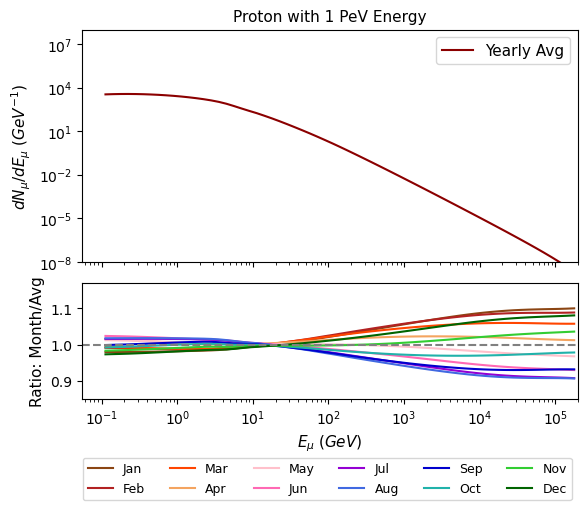

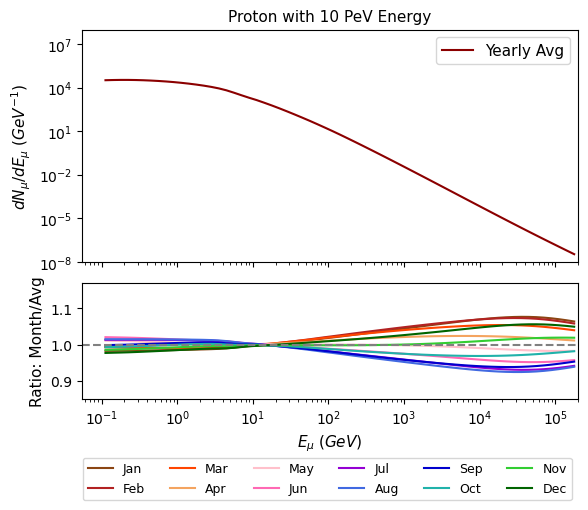

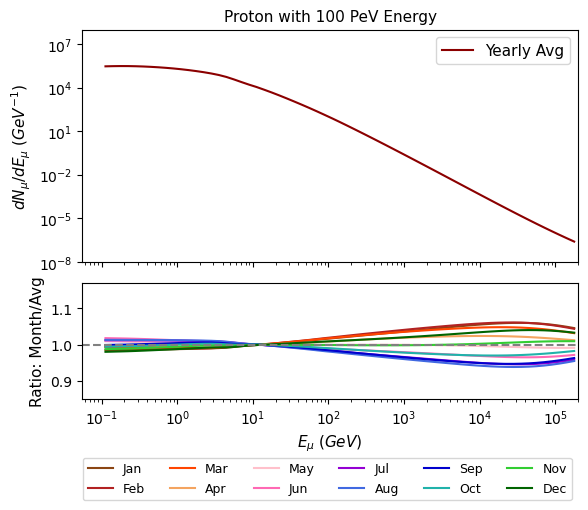

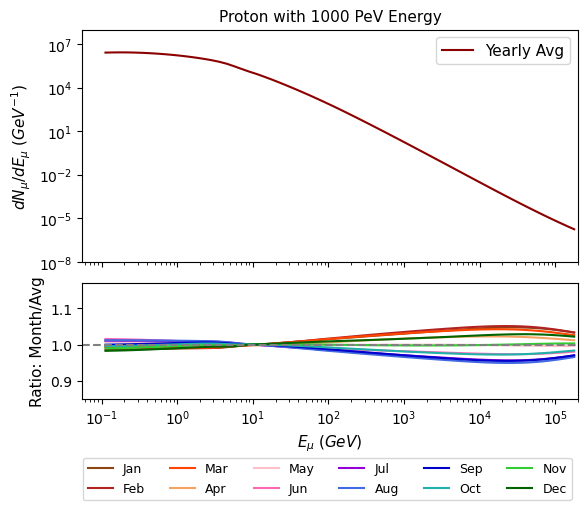

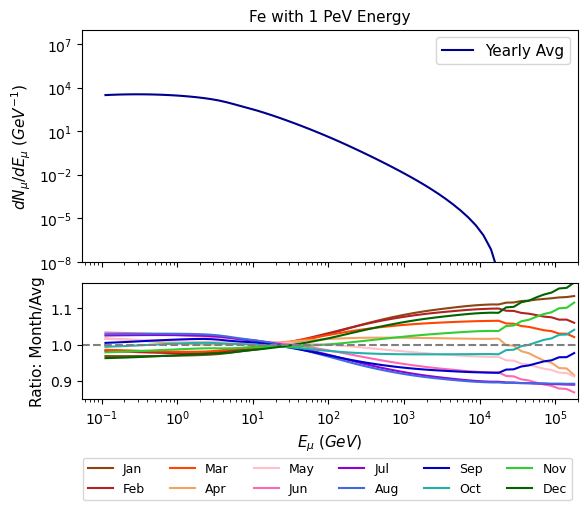

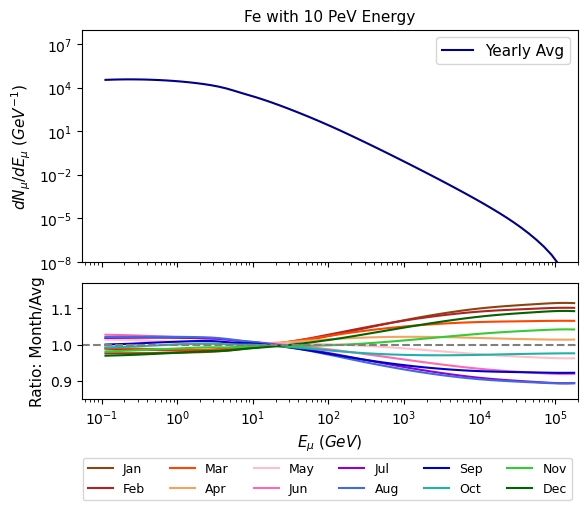

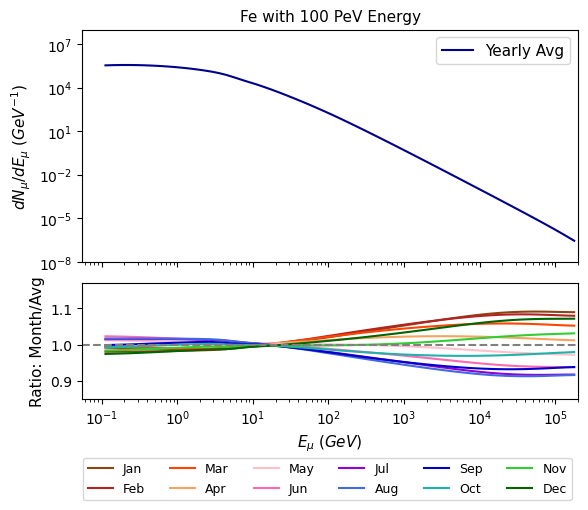

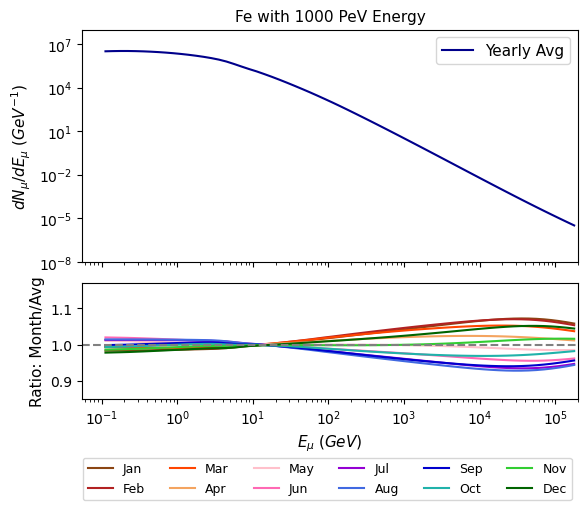

In [29]:
for particle in ['Proton', 'Fe']:
    for energy in [1, 10, 100, 1000]:
        fig, ax = plt.subplots(2, 1, sharex = True, gridspec_kw = {'height_ratios': (8,4) , 'hspace': 0.12})
        
        E_grid_avg, dNdE_avg = np.loadtxt('Spectra\{}\{}PeV\Average_{}PeV.txt'.format(particle, energy, energy), unpack=True)
        mask = (E_grid_avg > 0.1)*(E_grid_avg < 2e5) ## Keep for plotting purposes

        if particle == 'Proton':
              ax[0].loglog(E_grid_avg[mask], dNdE_avg[mask], color = 'darkred', label = 'Yearly Avg')
        if particle == 'Fe':
            ax[0].loglog(E_grid_avg[mask], dNdE_avg[mask], color = 'darkblue', label = 'Yearly Avg')

        for j in range(12):
            month = months[j]
            E_grid, dNdE = np.loadtxt('Spectra\{}\{}PeV\{}_{}PeV.txt'.format(particle, energy, month, energy), unpack=True)
            ax[1].plot(E_grid[mask], dNdE[mask]/dNdE_avg[mask], color = colors[j], label = month[0:3]) 
        
        ax[1].axhline(1, color = 'grey', ls = '--')
        
        ax[1].set_xlabel(r'$E_\mu \;(GeV)$', fontsize = 11)
        ax[1].set_ylabel('Ratio: Month/Avg', fontsize = 11)
        ax[1].set_xlim(0, 2e5)
        ax[1].set_ylim(0.85, 1.17)
        ax[0].set_ylim(1e-8, 1e8)

        ax[0].set_ylabel(r'$dN_\mu / dE_\mu \; (GeV^{-1})$', fontsize = 11)
        ax[0].legend(fontsize = 11)
        ax[1].legend(bbox_to_anchor=(1, -0.45), loc='upper right',  ncol=6, fontsize = 9)
        ax[0].set_title('{} with {} PeV Energy'.format(particle, energy), fontsize = 11)

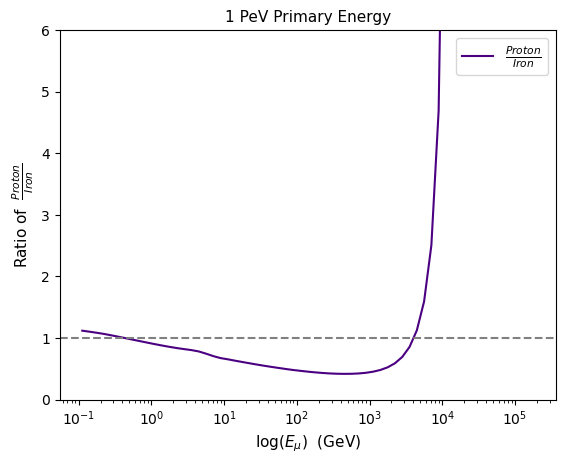

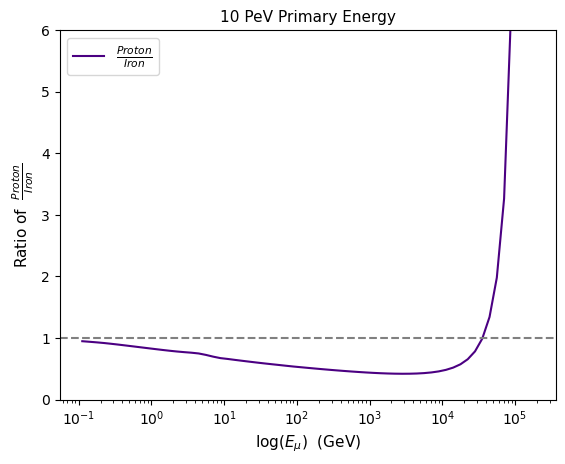

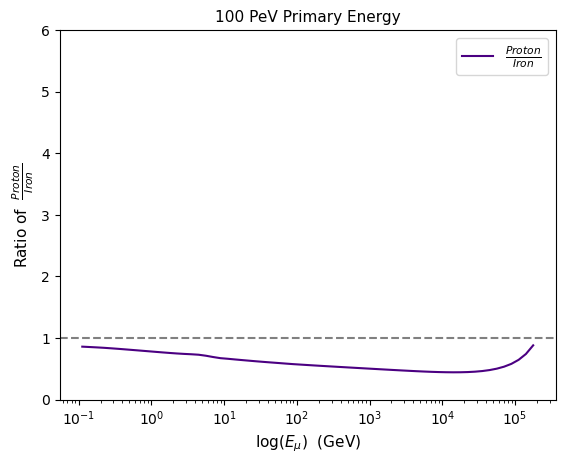

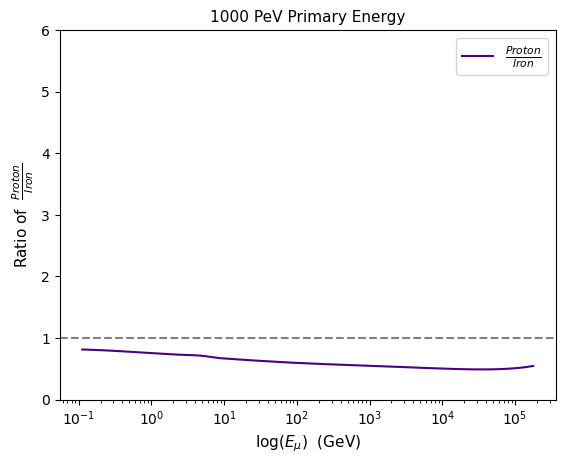

In [31]:
for energy in [1, 10, 100, 1000]:
    fig, ax = plt.subplots(1,1)
    E_avg, dNdE_p_avg = np.loadtxt('Spectra\{}\{}PeV\Average_{}PeV.txt'.format('Proton', energy, energy), unpack=True)
    E_avg, dNdE_fe_avg = np.loadtxt('Spectra\{}\{}PeV\Average_{}PeV.txt'.format('Fe', energy, energy), unpack=True)
    ax.plot(E_avg[mask], (dNdE_p_avg[mask] /dNdE_fe_avg[mask]), color = 'indigo', label = r'$\frac{Proton}{Iron}$' )
    ax.set_xscale('log')
    ax.set_ylabel('Ratio of  ' + r'$\frac{Proton}{Iron}$', fontsize = 11)
    ax.axhline(1, color = 'grey', ls = '--')
    ax.set_xlabel('log(' + r'$E_\mu$' + ')  (GeV)', fontsize = 11)
    ax.set_ylim(0, 6)
    ax.legend(fontsize = 11)
    ax.set_title('{} PeV Primary Energy'.format(energy), fontsize = 11)

### <font color = 'darkblue'> **Sanity Check** </font>


In [17]:
# Caluclating the number of muons using a function from MCEq (most accurate)
calc_mu = num_muons(1e6, 'p', 'January')
print('___________________________________')
print('Actual Value: The number of muons in an 10 PeV proton shower in January is {:.3f} muons'.format(calc_mu))


# Numerically integrating the spectrum
E_grid, dNdE = np.loadtxt('{}\{}PeV\{}_{}PeV.txt'.format('Proton', '1', 'January', '1'), unpack=True)
mask2 = (E_grid > 500) # only focuses on energies above 500 GeV

## Using Simpson integration method to find the number of muons
tot_mu = scipy.integrate.simpson(dNdE[mask2], x = E_grid[mask2]) # Total number of muons
print('Simpsons Method: The number of muons in an 1 PeV proton shower in January is {:.3f} muons'.format(tot_mu))

## Using the new way (smaller bins)
spline = scipy.interpolate.CubicSpline(E_grid, dNdE)
tot_mu = scipy.integrate.quad(lambda x : spline(x), 500, 1e5) #returns the answer plus the uncertainty -- only take first index for actual value
print('Spline Method: The number of muons in an 1 PeV proton shower in January is {:.3f} muons'.format(tot_mu[0]))

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
___________________________________
Actual Value: The number of muons in an 10 PeV proton shower in January is 11.098 muons
Simpsons Method: The number of muons in an 1 PeV proton shower in January is 9.209 muons
Spline Method: The number of muons in an 1 PeV proton shower in January is 11.170 muons


Note that the difference between the computational method and simpson integration is simply due to the bin widths that I previously set, meaning that if I were to decrease the widths of the bins, the result should match up.
* Using the spline method that Stef introduced to me, I was able to take smaller bin sizes thus getting a more accurate result